In [8]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import math
import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch.utils import data
from typing import Dict, List, Tuple
import tqdm
from torchvision.datasets import video_utils
import os
from PIL import Image

# Project imports
from src.dataset import ClothesDataLoader, ClothesDataset
from src.config import Config

In [9]:
seed = 22
torch.manual_seed(seed)
torch.torch.cuda.manual_seed_all(seed)
torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built() and torch.device != "cuda":
  device = torch.device("mps")
print(device)

mps


In [11]:
# Type here the path for the data set
dataset_path = os.path.join("datasets", "zalando-hd-resized")
!pwd

# Dowload the dataset only if it does not exist
if (os.path.exists(dataset_path)):
  print("Dataset already downloaded")
else:
  print("Dowloading dataset")
  os.makedirs(dataset_path, exist_ok=True)
  path_components = dataset_path.split(os.path.sep)
  new_path = os.path.sep.join(path_components[:-1])
  with open("path_check.tmp", 'w') as file:
    file.write(new_path)
  !wget https://www.dropbox.com/s/10bfat0kg4si1bu/zalando-hd-resized.zip
  !echo "Extracting the dataset. Please wait...."
  !unzip zalando-hd-resized.zip -d `cat path_check.tmp` > /dev/null
  !rm path_check.tmp
  !rm zalando-hd-resized.zip
  print("Done")

/Users/acabanas/dev/forks/clothes-extractor/Jupyters
Dataset already downloaded


In [12]:
# TODO: this should be declared in the Config class
hparams = {
    'batch_size':10,
    'num_epochs':5,
    'learning_rate':0.0002,
    'betas':(0.5, 0.999),
    'noise_size':100,
    'num_val_samples':25,
    'num_classes':10,
    'num_input_channels':1,
}

In [13]:
load_height = 28
load_width = 28

cfg = Config()
cfg.batch_size = hparams["batch_size"]
cfg.dataset_dir = dataset_path
cfg.load_height = 28
cfg.load_width = 28

# TODO: we should probably remove the dataset_mode from the config since it's a variable parameter
cfg.dataset_mode = "test"
test_dataset = ClothesDataset(cfg)

cfg.dataset_mode = "train"
train_dataset = ClothesDataset(cfg)


test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size)

Loading image: 08020_00.jpg 2


/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


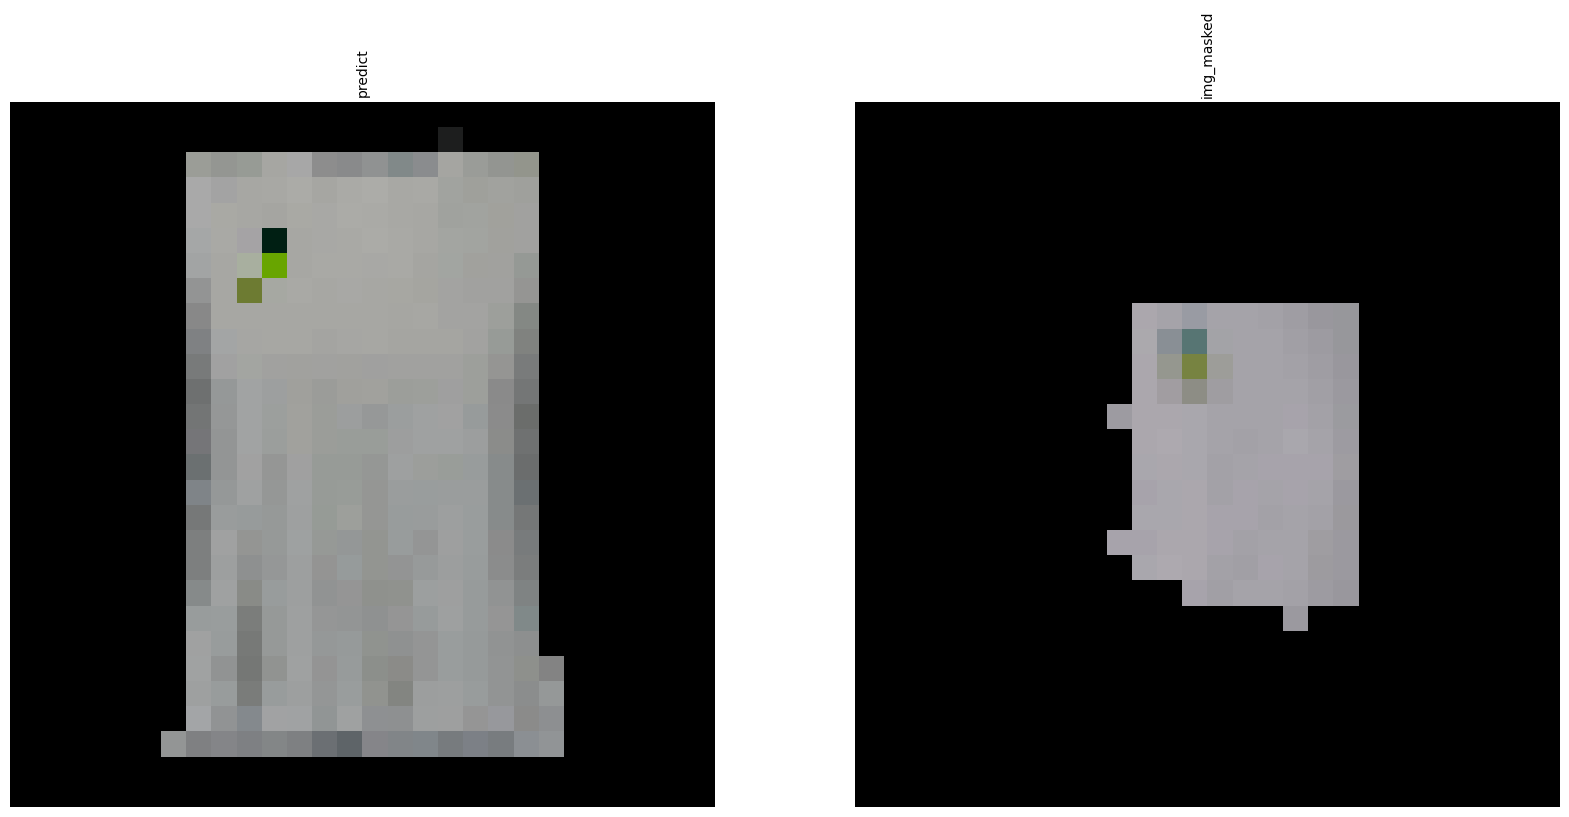

In [14]:
image = train_dataset[2]

# image_keys = ["img", "cloth", "cloth_mask", "predict", "agnostic_mask", "mask_body_parts", "mask_body", "centered_mask_body", "img_masked"]
image_keys = ["predict", "img_masked"]
fig, axes = plt.subplots(1, len(image_keys), figsize=(20, 20))

for ax, key in zip(axes, image_keys):
    ax.imshow(image[key].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(key, rotation=90, fontsize=10)

# Defining the UNET
![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [16]:
# #@title Unet

#TODO:

class SelfAttention(nn.Module):
    '''
    Similar to the Transformer Architecture, this network has self-attention blocks.
    '''
    def __init__(self, n_channels):
      super().__init__()
      n_channels_out = n_channels//4
      self.query = nn.Linear(n_channels, n_channels_out, bias=False)
      self.key = nn.Linear(n_channels, n_channels_out, bias=False)
      self.value = nn.Linear(n_channels, n_channels, bias=False)
      self.gamma = nn.Parameter(torch.tensor([0.0]))

    def forward(self, x):
      B, C, H, W = x.shape

      x = x.permute(0, 2, 3, 1).view(B, H * W, C) # Shape: [B, H*W, C]

      q = self.query(x) # [B, H*W, C]
      k = self.key(x) # [B, H*W, C]
      v = self.value(x) # [B, H*W, C]

      attn = F.softmax(torch.bmm(q, k.transpose(1,2)), dim=1) # Shape: [B, H*W, H*W]
      out = self.gamma * torch.bmm(attn, v) + x # Shape: [B, H*W, C]

      out = out.permute(0, 2, 1).view(B, C, H, W).contiguous()

      return out


class ResidualConvBlock(nn.Module):
    '''
    The following are resnet block, which consist of convolutional layers, followed by batch normalization and residual connections.
    '''
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [
            ResidualConvBlock(in_channels, in_channels, True),
            ResidualConvBlock(in_channels, in_channels, True),
            ResidualConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels, True),
            ResidualConvBlock(out_channels, out_channels, True),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class Unet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, num_classes: int = 10):
        super(Unet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.attn1 = SelfAttention(n_feat)

        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.attn2 = SelfAttention(2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.attn1up = SelfAttention(n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.attn2up = SelfAttention(n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )
        self.n_classes=10

    def forward(self, x):

        # Downsampling
        x = self.init_conv(x)
        down1 = self.attn1(self.down1(x))
        down2 = self.attn2(self.down2(down1))

        hiddenvec = self.to_vec(down2)

        # Upsampling
        up1 = self.up0(hiddenvec)

        condition = up1
        up2 = self.attn1up(self.up1(condition, down2))

        condition = up2

        up3 = self.attn2up(self.up2(condition, down1))
        out = self.out(torch.cat((up3, x), 1))
        return out


In [17]:
def visualize_nn_output(output, image_index=0):
    output = output[image_index].squeeze().detach().cpu().numpy()

    if output.shape[0] in [3, 4]:  # RGB or RGBA
        output = np.transpose(output, (1, 2, 0))

    plt.imshow(output)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


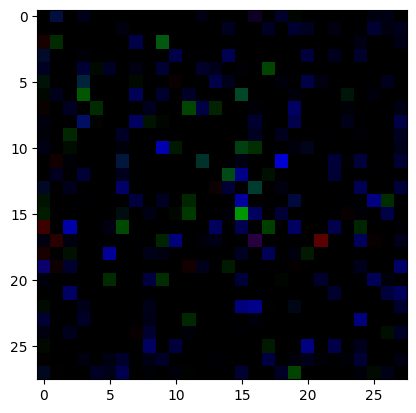

In [18]:
m = Unet(in_channels=3, n_feat=32)
inp = torch.randn(2,3,28,28) #As a sanity check, we define a random tensor with the same shape as an input image, to make sure that we can forward it to our network
out = m(inp)

visualize_nn_output(out)

In [19]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs in train_dataloader:
            target = inputs["predict"]
            source = inputs["img_masked"]
            optimizer.zero_grad()

            outputs = model(source)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_dataloader)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs in val_dataloader:
                target = inputs["predict"]
                source = inputs["img_masked"]

                outputs = model(inputs)
                loss = criterion(outputs, target)

                running_loss += loss.item()

        avg_val_loss = running_loss / len(val_dataloader)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}')

    print('Finished Training')
    return model


In [20]:
def run_model_on_image(model, dataset, image_index):
    model.eval()
    
    image = dataset[image_index]
    image = image["img_masked"].unsqueeze(0)

    
    with torch.no_grad():
        output = model(image)

    return output


In [ ]:
import torch
import torch.optim as optim
from torch.nn import L1Loss

criterion = L1Loss()
optimizer = optim.Adam(m.parameters(), lr=hparams["learning_rate"])

num_epochs = hparams["num_epochs"]
trained_model = train_model(m, train_dataloader, test_dataloader, criterion, optimizer, num_epochs)


Loading image: 10224_00.jpg 0
Loading image: 12308_00.jpg 1
Loading image: 08020_00.jpg 2
Loading image: 11066_00.jpg 3
Loading image: 05020_00.jpg 4
Loading image: 10814_00.jpg 5
Loading image: 08994_00.jpg 6
Loading image: 07690_00.jpg 7
Loading image: 01492_00.jpg 8
Loading image: 03456_00.jpg 9
Loading image: 11772_00.jpg 10
Loading image: 08282_00.jpg 11
Loading image: 03395_00.jpg 12
Loading image: 10520_00.jpg 13
Loading image: 14603_00.jpg 14
Loading image: 03373_00.jpg 15
Loading image: 06852_00.jpg 16
Loading image: 06848_00.jpg 17
Loading image: 02418_00.jpg 18
Loading image: 01279_00.jpg 19
Loading image: 04869_00.jpg 20
Loading image: 11233_00.jpg 21
Loading image: 07660_00.jpg 22
Loading image: 07498_00.jpg 23
Loading image: 01600_00.jpg 24
Loading image: 05969_00.jpg 25
Loading image: 09497_00.jpg 26
Loading image: 04124_00.jpg 27
Loading image: 05895_00.jpg 28
Loading image: 10385_00.jpg 29
Loading image: 04959_00.jpg 30
Loading image: 11031_00.jpg 31
Loading image: 007

In [ ]:
out = run_model_on_image(m, train_dataset, 0)
visualize_nn_output(out)

In [ ]:
import src.dataset as dataset
import importlib
importlib.reload(dataset)